In [41]:
import pandas as pd
import numpy as np

weather_path = "../data/sa/au_adelaide_act.csv"
solar_path = "../data/sa/au_sa_iso_satellite_pv_load_act.csv"
total_path = '../data/sa/au_sa_total_load_complete.csv'
load_path = '../data/sa/au_sa_load_act.csv'

# load and store datasets
weather = pd.read_csv(weather_path, na_values='-99')
solar = pd.read_csv(solar_path, na_values='-99')
total = pd.read_csv(total_path, na_values='-99', parse_dates=['datetime'])
load = pd.read_csv(load_path, na_values='-99')

Combine date and time to datetime for datasets where this is necessary - all but `total`.

In [42]:
def to_datetime_df(df):
    date = df['date'].astype('str')
    time = df['time'].astype('str').str.pad(4, fillchar='0')
    df['datetime'] = pd.to_datetime(date + time, format = '%Y%m%d%H%M')
    df_d = df.drop(['date', 'time'], axis = 1)
    return df_d

weather_d = to_datetime_df(weather)
solar_d = to_datetime_df(solar)
load = to_datetime_df(load)

Weather data is hourly, so upsample to 30 minute increments and use linear interpolation to fill values.

In [43]:
weather_resample = weather_d.set_index('datetime').resample('30min').asfreq()
weather_interpolate = weather_resample.interpolate()
weather_interpolate.head()

,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
datetime,,,,,,,
2016-01-01 00:00:00,27.40,3.0,5.0,80.0,19.0,0.0,NaN
2016-01-01 00:30:00,26.10,5.0,5.0,205.0,27.0,0.0,NaN
2016-01-01 01:00:00,24.80,7.0,5.0,330.0,35.0,0.0,NaN
2016-01-01 01:30:00,24.25,5.5,4.5,315.0,49.0,0.0,NaN
2016-01-01 02:00:00,23.70,4.0,4.0,300.0,63.0,0.0,NaN


Now, join weather and solar on matching timestamps.

In [44]:
weather_solar = pd.merge(weather_interpolate, solar_d, on='datetime', how='inner', copy=False, validate='1:1')
weather_solar.rename({'load_act': 'pv_est'}, axis=1, inplace=True)
weather_solar.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989


Now join again with net load.

In [45]:
ws_load = pd.merge(weather_solar, load, on='datetime', how='inner', copy=False, validate='1:1')
ws_load.rename({'load_act': 'net_load'}, axis=1, inplace=True)
ws_load.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122


And join again with total load.

In [46]:
merged = pd.merge(ws_load, total, on='datetime', how='inner', copy=False, validate='1:1')
merged.rename({'load_act': 'total_load'}, axis=1, inplace=True)
merged.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288,1136.79
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237,1054.87
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189,1002.35
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150,971.54
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122,943.68


Ensure result is sorted by timestamp.

In [47]:
merged.sort_values(by='datetime', inplace=True)

Plot all columns against timestamp as a sanity check.

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

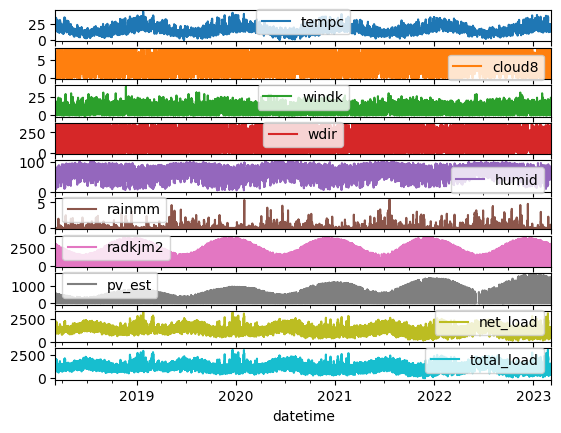

In [48]:
merged.plot(x='datetime', subplots=True)

Write to file.

In [49]:
merged.to_csv('../data/sa/merged_interpolated.csv', index=False)

Additionally create hourly merge set without interpolation.

In [50]:
solar_hour = solar_d.set_index('datetime').resample(rule='H', closed='right', label='right').mean()
load_hour = load.set_index('datetime').resample(rule='H', closed='right', label='right').mean()
total_hour = total.set_index('datetime').resample('H', closed='right', label='right').mean()

weather_solar_hour = pd.merge(weather_d, solar_hour, on='datetime', how='inner', copy=False, validate='1:1')
weather_solar_hour.rename({'load_act': 'pv_est'}, axis=1, inplace=True)
ws_load_hour = pd.merge(weather_solar_hour, load_hour, on='datetime', how='inner', copy=False, validate='1:1')
ws_load_hour.rename({'load_act': 'net_load'}, axis=1, inplace=True)
merged_hour = pd.merge(ws_load_hour, total_hour, on='datetime', how='inner', copy=False, validate='1:1')
merged_hour.rename({'load_act': 'total_load'}, axis=1, inplace=True)
merged_hour.sort_values(by='datetime', inplace=True)
merged_hour = merged_hour.set_index('datetime').reset_index()
print('Column order matches:', np.all(merged.columns == merged_hour.columns))
merged_hour.head()

Column order matches: True


,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
0,2018-03-06 10:00:00,21.5,1.0,16.0,140.0,40.0,0.0,2340.0,347.1110,1262.5,1095.830
1,2018-03-06 11:00:00,23.0,2.0,15.0,150.0,34.0,0.0,2800.0,458.0190,1169.5,986.945
2,2018-03-06 12:00:00,24.1,2.0,11.0,140.0,30.0,0.0,3090.0,537.2945,1112.0,943.830
3,2018-03-06 13:00:00,25.3,0.0,17.0,150.0,26.0,0.0,3110.0,567.1440,1093.5,915.595
4,2018-03-06 14:00:00,25.3,1.0,14.0,140.0,29.0,0.0,2850.0,562.2175,1105.0,893.565


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

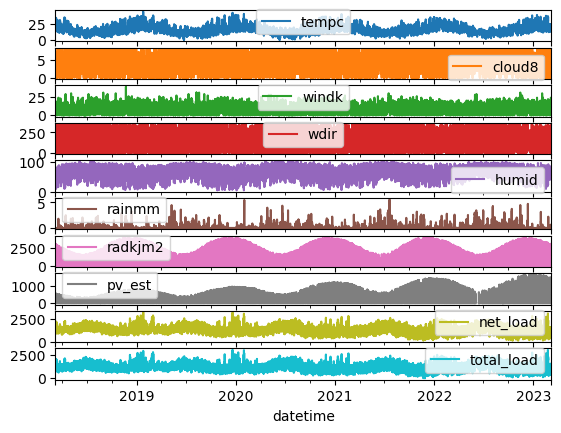

In [51]:
merged_hour.plot(x='datetime', subplots=True)

In [52]:
print(merged_hour.isna().mean())
((merged.describe() - merged_hour.describe()) / merged.describe()).round(3)

datetime      0.000000
tempc         0.000114
cloud8        0.000388
windk         0.000114
wdir          0.000114
humid         0.000114
rainmm        0.000524
radkjm2       0.000114
pv_est        0.012425
net_load      0.000000
total_load    0.000000
dtype: float64


,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
count,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
std,-0.003,-0.033,-0.019,-0.039,-0.008,-0.029,-0.007,0.003,0.005,0.005
min,-0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,-0.055,0.345
25%,0.000,0.000,0.000,0.000,0.010,NaN,NaN,NaN,-0.001,-0.002
50%,0.000,0.000,0.000,0.000,0.000,NaN,0.333,-0.753,-0.001,-0.001
75%,0.000,-0.077,0.000,0.000,0.005,1.000,0.000,0.005,0.001,0.001
max,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.004,0.003


Strange that pv median and minimum total load changed significantly?

In [53]:
merged.total_load.min(), merged_hour.total_load.min()

(-18.5016666666667, -12.127500000000015)

Ah, right, there would be a high relative change at small scale. But why is it negative???

In [54]:
merged_hour[merged_hour.total_load < 0]

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
32547,2021-11-21 13:00:00,20.8,3.0,15.0,160.0,45.0,0.0,3890.0,1404.6645,107.0,-1.5475
32692,2021-11-27 14:00:00,23.6,1.0,11.0,140.0,35.0,0.0,3530.0,1381.6985,209.5,-12.1275


<Axes: xlabel='datetime'>

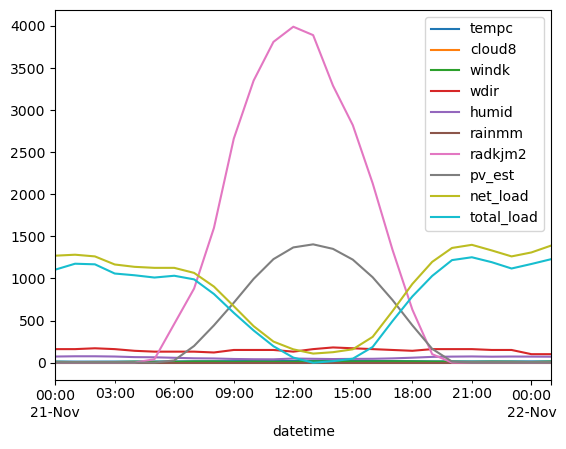

In [55]:
merged_hour.iloc[32534:32560].plot(x='datetime')

<Axes: xlabel='datetime'>

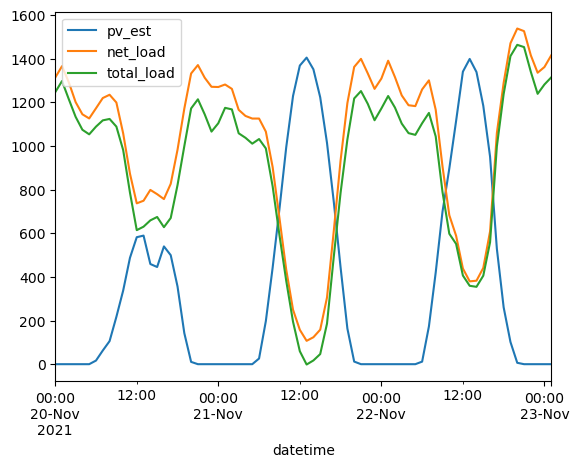

In [56]:
merged_hour.iloc[32510:32584, [0, 8, 9, 10]].plot(x='datetime')

In [57]:
merged_hour[merged_hour.total_load < 0]['datetime'].dt.weekday

32547    6
32692    5
Name: datetime, dtype: int64

Weekend, high PV generation, and the neighboring hours/days fit the pattern. There could very well have been significantly less demand that day, such that PV was sufficient for all load within that hour.

In [58]:
merged_hour.to_csv('../data/sa/merged.csv', index=False)